# Groups

In [ ]:
import numpy as np

model_name = "pythia_1b"
n_tokens = 10_000_000
method = "angular"
n_tokens_label = f"{float(n_tokens) / 1e6:.1f}M"

dist = np.nanmean(np.load(f"dist/{model_name}_{n_tokens_label}_{method}.npy"), axis=0)
nl = dist.shape[0]
dist.shape

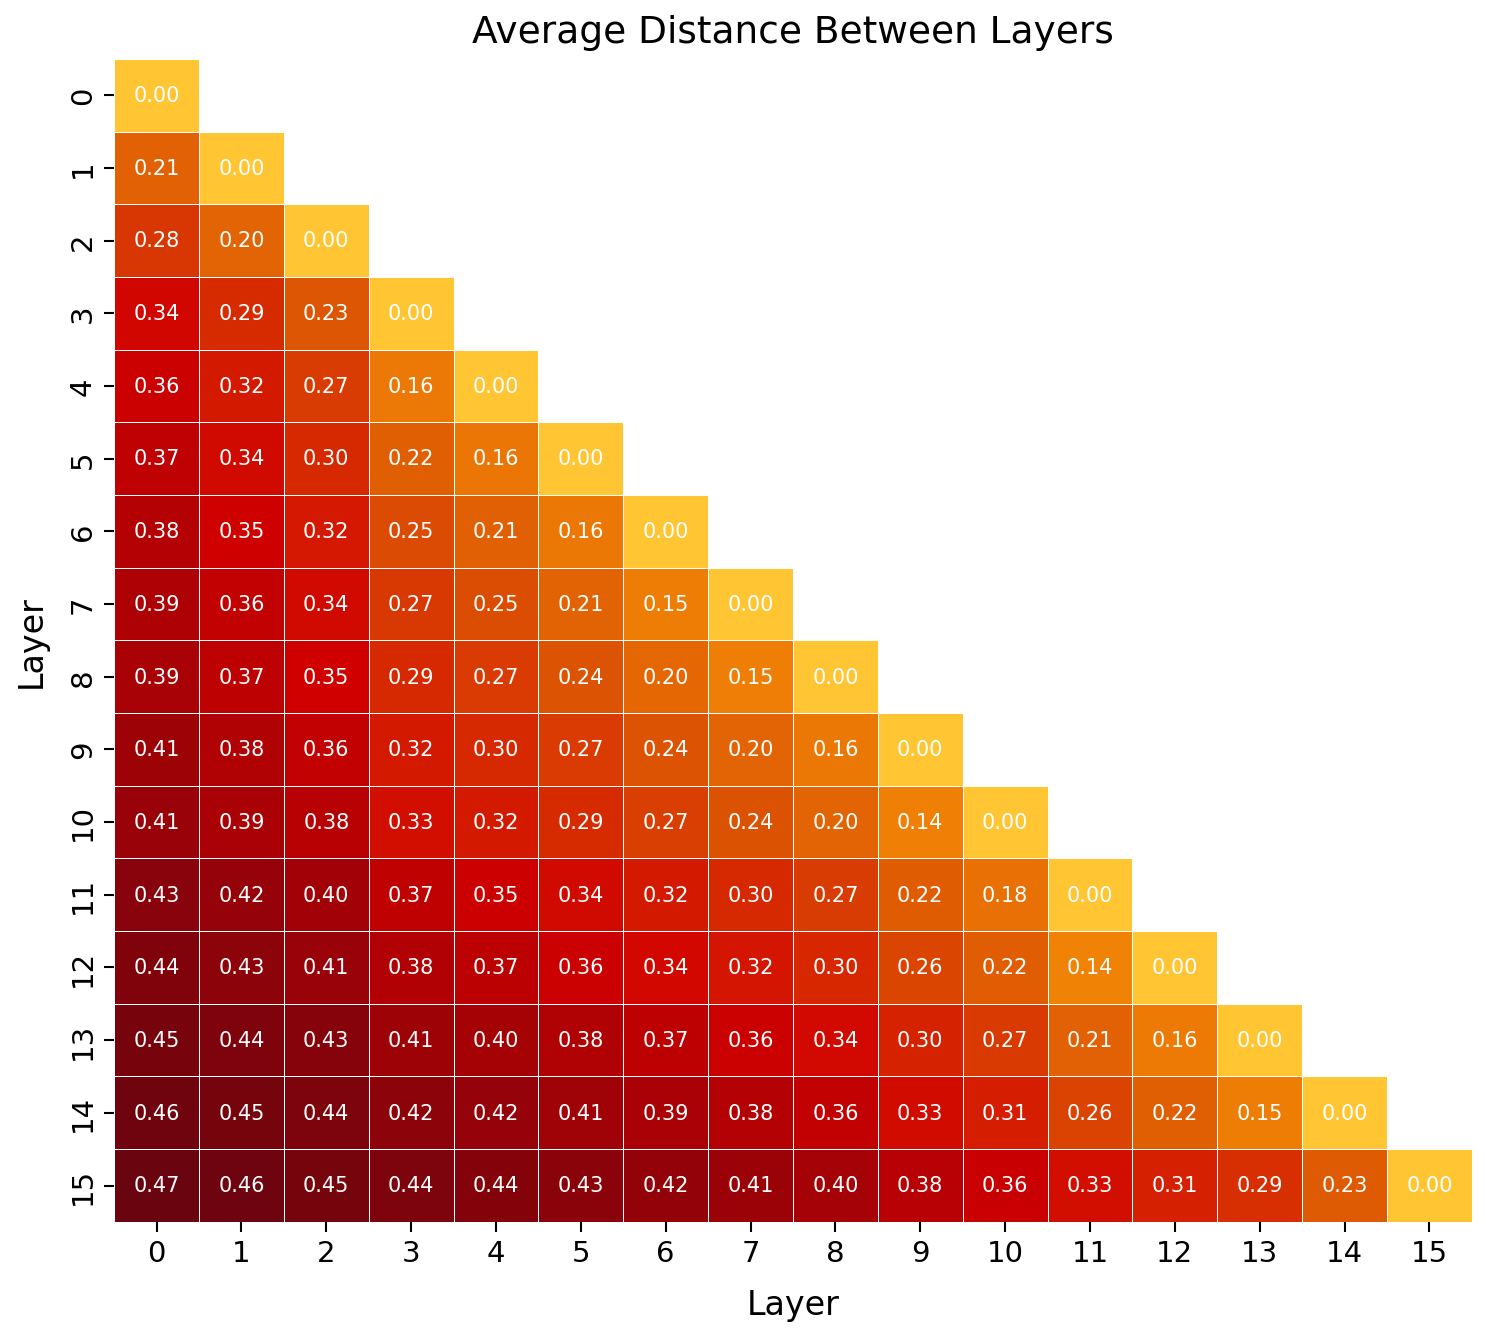

In [24]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

from group_sae.utils import cmap

os.makedirs("img", exist_ok=True)

sns.set_context("paper")
scale = nl / 25
fig, ax = plt.subplots(1, 1, figsize=(int(16 * scale), int(15 * scale)), dpi=150, layout="tight")  # 12, 11

cmap.set_bad("white")
dist_bad = np.copy(dist)
dist_bad[np.triu_indices_from(dist_bad, 1)] = np.nan
mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)mask = np.zeros_like(dist, dtype=bool)
mask[np.tril_indices_from(mask)] = True
# for text, show_annot in zip(ax.texts, mask.ravel()):
#     text.set_visible(show_annot)

sns.heatmap(
    dist_bad,
    cmap=cmap,
    vmin=0,
    annot=True,
    fmt=".2f",
    ax=ax,
    mask=np.triu(dist),
    square=False,
    linewidths=0.3,
    linecolor="white",
    cbar=False,
    annot_kws={"size": 10, "color": "white"},
)

ax.set_title("Average Distance Between Layers", pad=8, fontsize=18)
# ax.set_ylim(0, 1)

ax.set_xlabel("Layer", labelpad=10, fontsize=16)
ax.set_ylabel("Layer", labelpad=10, fontsize=16)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.savefig(f"img/{model_name}_{n_tokens}.pdf", dpi=300, bbox_inches="tight")

In [25]:
import json

from sklearn.cluster import AgglomerativeClustering

scores = []

X = np.array(dist[:-1, :-1])
X[np.isinf(X)] = 0
X[np.isnan(X)] = 0
X = np.nan_to_num(X)

clusters = {}
unique_clusters = set()
training_clusters = {}

for k in range(1, nl-1):
    clustering = AgglomerativeClustering(
        n_clusters=k, linkage="complete", compute_distances=True
    ).fit(X)

    cluster_dist = [X[clustering.labels_ == i][:, clustering.labels_ == i].max() for i in range(k)]
    print(f"K{k}:\t", clustering.labels_, "AMD:", np.round(np.mean(cluster_dist), 3)) # Weight by cluster size!

    j = 0
    for i in range(k):
        c = np.arange(nl-1)[clustering.labels_ == i].astype(str)
        if len(c) > 1 and tuple(c) not in unique_clusters:
            unique_clusters.add(tuple(c))
            training_clusters[f"k{k}-c{j}"] = list(c)
            j += 1

    clusters[k] = {
        "labels": [str(i) for i in clustering.labels_],
        "amd": float(np.round(np.mean(cluster_dist), 3))
    }

print("Unique clusters:", len(unique_clusters))
clusters.update({"training_clusters": training_clusters})

with open(f"maad/{model_name}.json", "w") as f:
    json.dump(clusters, f)

K1:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] AMD: 0.459
K2:	 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1] AMD: 0.364
K3:	 [1 1 1 1 1 2 2 2 2 0 0 0 0 0 0] AMD: 0.309
K4:	 [0 0 0 0 0 2 2 2 2 1 1 1 1 3 3] AMD: 0.25
K5:	 [4 4 1 1 1 2 2 2 2 0 0 0 0 3 3] AMD: 0.225
K6:	 [4 4 1 1 1 0 0 0 0 2 2 5 5 3 3] AMD: 0.191
K7:	 [1 1 0 0 0 4 4 2 2 6 6 5 5 3 3] AMD: 0.174
K8:	 [0 0 7 3 3 4 4 2 2 6 6 5 5 1 1] AMD: 0.139
K9:	 [8 4 7 3 3 1 1 2 2 6 6 5 5 0 0] AMD: 0.1
K10:	 [8 9 7 1 1 0 0 2 2 6 6 5 5 4 3] AMD: 0.075
K11:	 [ 8  9  7  0  0 10  3  2  2  6  6  5  5  4  1] AMD: 0.053
K12:	 [ 8  9  7 11  6 10  3  0  0  2  2  5  5  4  1] AMD: 0.036
K13:	 [ 8  9  7 11  6 10  3 12  5  0  0  2  2  4  1] AMD: 0.022
K14:	 [ 8  9  7 11 13 10  3 12  5  6  2  0  0  4  1] AMD: 0.01
Unique clusters: 14


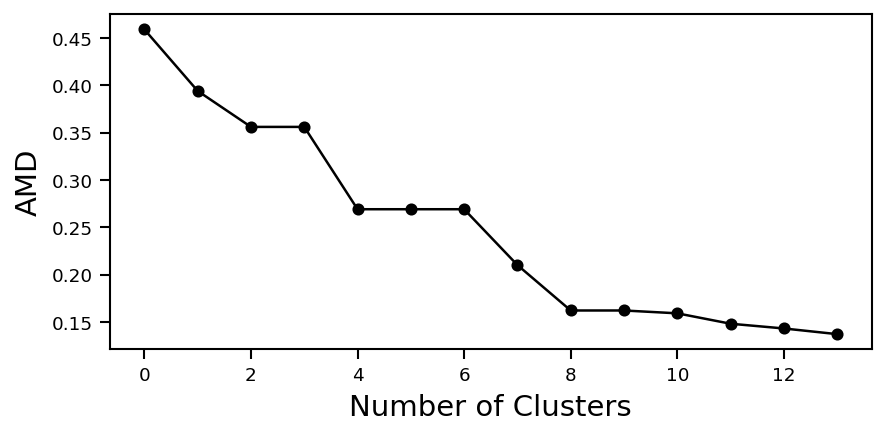

In [26]:
amds = [clusters[k]["amd"] for k in clusters.keys() if k != "training_clusters"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
ax.plot(amds, marker="o", linestyle="-", color="black")
ax.set_xlabel("Number of Clusters", fontsize=14)
ax.set_ylabel("AMD", fontsize=14)
plt.tight_layout()